# Adaptive Intelligence COM3240

## Collective Report B

This notebook contains the code accompanying the collective report. It is heavily adapted from Lab 8.

The update rule for Q values and the SARSA algorithm are attached below.

\begin{align}
\Delta Q (s,a) &= \eta\left[r- \left(Q(s,a) - \gamma Q(s', a') \right)\right] 
\end{align}

<img src="http://bitsandchips.me/COM3240_Adaptive_Intelligence/Lecture8/icons/sarsa_algorithm.png" width="500"/>


In [1]:
###
### Imports and utilities!
###

import numpy as np
import matplotlib.pyplot as plt
from enum import Enum, unique, auto
from sklearn.preprocessing import normalize
import math

font_size = 13

def log_progress(sequence, every=None, size=None, name=''):
    from ipywidgets import IntProgress, HTML, HBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = HBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 0):
            if index % every == 0:
                if is_iterator:
                    label.value = '{name} {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name} {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        index += 1
        progress.value = index
        label.value = "{name} {index} / {size}".format(
            name=name,
            index=str(index or '?'),
            size=size
        )

In [2]:
###
### Object Definitions
###

class Grid():
    def __init__(self, shape, terminal_positions = [], rewards=[]):
        self.grid = np.zeros(shape)
        self.terminal_positions = terminal_positions
        self.rewards = rewards
        
    def random_position(self):
        return (
            np.random.randint(self.get_shape()[0]),
            np.random.randint(self.get_shape()[1])
        )
    
    def get_shape(self):
        return self.grid.shape
    
    def get_size(self):
        max_x, max_y = self.get_shape()
        return max_x * max_y
    
    def is_terminal(self, position):
        return position in self.terminal_positions
    
    def as_vector(self, position):
        x, y = position
        v = np.zeros(self.get_shape())
        v[x,y] = 1
        return v.reshape(self.get_size(), 1)
    
    def get_possible_actions(self, position):
        possible_actions = [e for e in Action]
        x, y = position
        
        if y >= self.get_shape()[1] - 1:
            if (Action.NORTH in possible_actions):
                possible_actions.remove(Action.NORTH)
            if (Action.NORTH_WEST in possible_actions):
                possible_actions.remove(Action.NORTH_WEST)
            if (Action.NORTH_EAST in possible_actions):
                possible_actions.remove(Action.NORTH_EAST)
        if x >= self.get_shape()[0] - 1:
            if (Action.EAST in possible_actions):
                possible_actions.remove(Action.EAST)
            if (Action.NORTH_EAST in possible_actions):
                possible_actions.remove(Action.NORTH_EAST)
            if (Action.SOUTH_EAST in possible_actions):
                possible_actions.remove(Action.SOUTH_EAST)
        if y < 1:
            if (Action.SOUTH in possible_actions):
                possible_actions.remove(Action.SOUTH)
            if (Action.SOUTH_EAST in possible_actions):
                possible_actions.remove(Action.SOUTH_EAST)
            if (Action.SOUTH_WEST in possible_actions):
                possible_actions.remove(Action.SOUTH_WEST)
        if x < 1:
            if (Action.WEST in possible_actions):
                possible_actions.remove(Action.WEST)
            if (Action.NORTH_WEST in possible_actions):
                possible_actions.remove(Action.NORTH_WEST)
            if (Action.SOUTH_WEST in possible_actions):
                possible_actions.remove(Action.SOUTH_WEST)
            
        return possible_actions
    
    def __new_position_after_action(self, position, action):
        x, y = position
        if action in self.get_possible_actions(position):
            if action.vaguely(Action.NORTH):
                y += 1
            if action.vaguely(Action.EAST):
                x += 1
            if action.vaguely(Action.SOUTH):
                y -= 1
            if action.vaguely(Action.WEST):
                x -= 1
        return (x, y)
    
    def __reward_after_action(self, position, action):
        x, y = position
        if y >= self.get_shape()[1] and action.vaguely(Action.NORTH):
            return -1
        if x >= self.get_shape()[0] and action.vaguely(Action.EAST):
            return -1
        if y <= 0 and action.vaguely(Action.SOUTH):
            return -1
        if x <= 0 and action.vaguely(Action.WEST):
            return -1
        
        for reward_segment in self.rewards:
            loc, reward = reward_segment
            if self.__new_position_after_action(position, action) == loc:
                return reward
        
        return 0
    
    def perform(self, position, action):
        return (
            self.__new_position_after_action(position, action),
            self.__reward_after_action(position, action)
        )

class SarsaEnum(Enum):
    def _generate_next_value_(name, start, count, last_values):
        return count
    
@unique
class Action(SarsaEnum):
    NORTH = auto()
    NORTH_EAST = auto()
    EAST = auto()
    SOUTH_EAST = auto()
    SOUTH = auto()
    SOUTH_WEST = auto()
    WEST = auto()
    NORTH_WEST = auto()
    
    @classmethod
    def rand(cls):
        return cls(np.random.randint(len(cls)))
    
    def vaguely(self, action_to_compare):
        if action_to_compare == Action.NORTH:
            return self in [Action.NORTH, Action.NORTH_WEST, Action.NORTH_EAST]
        if action_to_compare == Action.EAST:
            return self in [Action.EAST, Action.NORTH_EAST, Action.SOUTH_EAST]
        if action_to_compare == Action.SOUTH:
            return self in [Action.SOUTH, Action.SOUTH_EAST, Action.SOUTH_WEST]
        if action_to_compare == Action.WEST:
            return self in [Action.WEST, Action.NORTH_WEST, Action.SOUTH_WEST]
        raise 'Action not recognised as main direction'
    
    def as_vector(self):
        v = np.zeros((len(type(self)), 1))
        v[self.value] = 1

        return v

In [3]:
###
### Homing Algorithm / SARSA Implementation
###

grid_shape = (4,3)
charging_point = (3,0)

def sarsa_homing_nn(n_episodes, learning_rate, epsilon, gamma):
    
    grid = Grid(grid_shape, terminal_positions = [charging_point], rewards=[(charging_point, 1)])
    max_choices = math.ceil(grid.get_size() ** 1.5)

    # Initialise weights randomly. Connects input neurons (state) to output neurons (actions). Weight is Q values.
    weights = np.random.rand(len(Action), grid.get_size())

    # Define info vectors (one position for each trial) and initialise it to zero
    r_history = np.zeros((1, n_episodes))
    steps_req_history = np.zeros((1, n_episodes))

    # Start the episode
    for episode in range(n_episodes):
        state = grid.random_position() # Initial state

        # Define and initialise at every episode the variables needed for SARSA
        input_v = np.zeros((grid.get_size(),1))
        output_v = np.zeros((len(Action),1))
        q_value = 0
        reward = 0
        steps_required = 0

        # Simulate the steps in the episode
        for step in range(max_choices):
            steps_required += 1
            input_v_ = grid.as_vector(state)
            
            # Compute state_q_values.  q_value = logsig(weights*input). q_value is 2x1, one value for each output neuron
            state_q_values = (1 / (1 + np.exp(-1 * weights.dot(input_v_)))).flatten()
            
            winning_actions = np.argwhere(state_q_values == np.max(state_q_values)).flatten()

            # Implement the policy
            explore = np.random.rand() < epsilon
            if explore:
                possible_actions = grid.get_possible_actions(state)
                action = np.random.choice(possible_actions)
            else:
                random_winner = np.random.choice(winning_actions)
                action = Action(random_winner)

            state, reward_ = grid.perform(state, action)
            output_v_ = action.as_vector() # Update weights only for action selected.
            
            
            # Update weights
            q_value_ = state_q_values[action.value]
            d_w = learning_rate * (reward - (q_value - (gamma * q_value_))) * output_v.dot(input_v.T)
            weights += d_w

            # Update variables for sarsa
            q_value = q_value_
            output_v = output_v_
            input_v = input_v_
            reward = reward_
            
            if grid.is_terminal(state):
                break
            

        # Update weights for the terminal state
        d_w = learning_rate * (reward - q_value) * output_v.dot(input_v.T)
        weights += d_w

        # Store info for the current episode
        r_history[0,episode] = reward
        steps_req_history[0,episode] = steps_required

    return (r_history, steps_req_history, weights)

In [4]:
###
### Parameter Setup
###

n_episodes = 25    # int > 0
learning_rates = [0.9, 0.1, 0.5] # real > 0
epsilons = [0.1, 0.5, 0.9]    # real >= 0; epsilon=0 Greedy, otherwise epsilon-Greedy
gammas = [0.9, 0.009, 0.09]         # 0 <= real <= 1
repetitions = 250   # int > 0

###
### Experiments
###

max_x, max_y = grid_shape
weight_shape = (len(Action), max_x*max_y)

lr_rewards = []
lr_steps = []
lr_weights = []

for lr in log_progress(learning_rates, name='Learning Rates'):
    rewards = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    steps_until_terminate = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    weight_m = np.zeros((repetitions, *weight_shape))

    # Start iterations over episodes
    for j in log_progress(range(repetitions), name="Repetitions"):
        rewards[j,:], steps_until_terminate[j,:], weight_m[j,:] = sarsa_homing_nn(n_episodes, lr, epsilons[0], gammas[0])
    
    lr_rewards.append(rewards)
    lr_steps.append(steps_until_terminate)
    lr_weights.append(weight_m)
    
ep_rewards = []
ep_steps = []
ep_weights = []

for ep in log_progress(epsilons, name='Epsilons'):
    rewards = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    steps_until_terminate = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    weight_m = np.zeros((repetitions, *weight_shape))

    # Start iterations over episodes
    for j in log_progress(range(repetitions), name="Repetitions"):
        rewards[j,:], steps_until_terminate[j,:], weight_m[j,:] = sarsa_homing_nn(n_episodes, learning_rates[0], ep, gammas[0])
    
    ep_rewards.append(rewards)
    ep_steps.append(steps_until_terminate)
    ep_weights.append(weight_m)
    
ga_rewards = []
ga_steps = []
ga_weights = []

for ga in log_progress(gammas, name='Discount Rates'):
    rewards = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    steps_until_terminate = np.zeros((repetitions, n_episodes))  # reward matrix. each row contains rewards obtained in one episode
    weight_m = np.zeros((repetitions, *weight_shape))

    # Start iterations over episodes
    for j in log_progress(range(repetitions), name="Repetitions"):
        rewards[j,:], steps_until_terminate[j,:], weight_m[j,:] = sarsa_homing_nn(n_episodes, learning_rates[0], epsilons[0], ga)
    
    ga_rewards.append(rewards)
    ga_steps.append(steps_until_terminate)
    ga_weights.append(weight_m)
        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

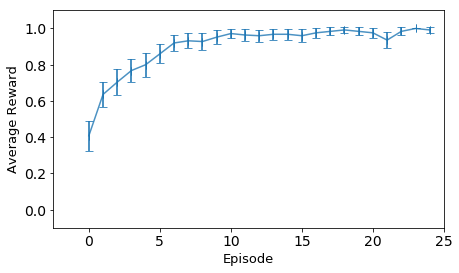

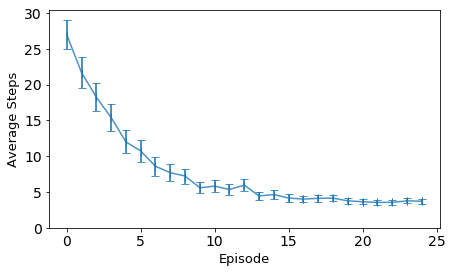

In [5]:
###
### Plotting average rewards and steps
###


fig, ((ax1)) = plt.subplots(1, 1, figsize=(7,4))

rewards = lr_rewards[0]
steps_until_terminate = lr_steps[0]

ax1_means = np.mean(rewards, axis = 0)
ax1_errors = 2 * np.std(rewards, axis = 0) / np.sqrt(repetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)

ax1.errorbar(np.arange(n_episodes), ax1_means, ax1_errors, 0, elinewidth = 2, capsize = 4, alpha =0.8)
ax1.set_xlabel('Episode',fontsize = font_size)
ax1.set_ylabel('Average Reward',fontsize = font_size)
ax1.axis((-(n_episodes/10.0),n_episodes,-0.1,1.1))
ax1.tick_params(axis = 'both', which='major', labelsize = 14)

plt.show()  

fig, ((ax2)) = plt.subplots(1, 1, figsize=(7,4))

ax2_means = np.mean(steps_until_terminate, axis = 0)
ax2_errors = 2 * np.std(steps_until_terminate, axis = 0) / np.sqrt(repetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)

ax2.errorbar(np.arange(n_episodes), ax2_means, ax2_errors, 0, elinewidth = 2, capsize = 4, alpha =0.8)
ax2.set_xlabel('Episode',fontsize = font_size)
ax2.set_ylabel('Average Steps',fontsize = font_size)
ax2.set_ylim(ymin=0)
# ax2.axis((-(n_episodes/10.0),n_episodes,-0.1,1.1))
ax2.tick_params(axis = 'both', which='major', labelsize = 14)

plt.show() 

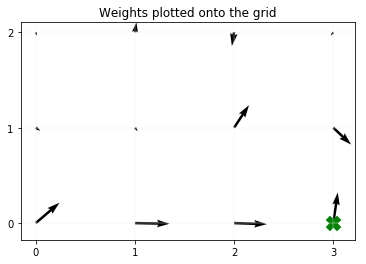

In [6]:
###
### Visualising the NN weights / Q-values
###

fig, ((ax1)) = plt.subplots(1, 1, figsize=(6,4))

weight_m = lr_weights[0]

# base_dir_vectors = np.array([[0,1],[1,0],[0,-1],[-1,0]])
base_dir_vectors = np.array([[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1]]) # 8 actions

max_x, max_y = grid_shape
a = np.einsum('iz,ij->zj', weight_m.mean(axis=0), base_dir_vectors)
# a = normalize(a, axis=1, norm='l2')
a = a.reshape((max_x, max_y, 2))

x,y = np.meshgrid(np.arange(max_x),np.arange(max_y))
charge_x, charge_y = charging_point

ax1.set_title("Weights plotted onto the grid")
ax1.grid(color='#eeeeee', alpha=0.2, linestyle='-', linewidth=2, drawstyle="steps-post")
ax1.set_xticks(np.arange(max_x))
ax1.set_yticks(np.arange(max_y))
Q = ax1.quiver(x,y, a[:,:,0], a[:,:,1])
ax1.scatter([charge_x],[charge_y], color='g', s=200, marker='X')
plt.show()

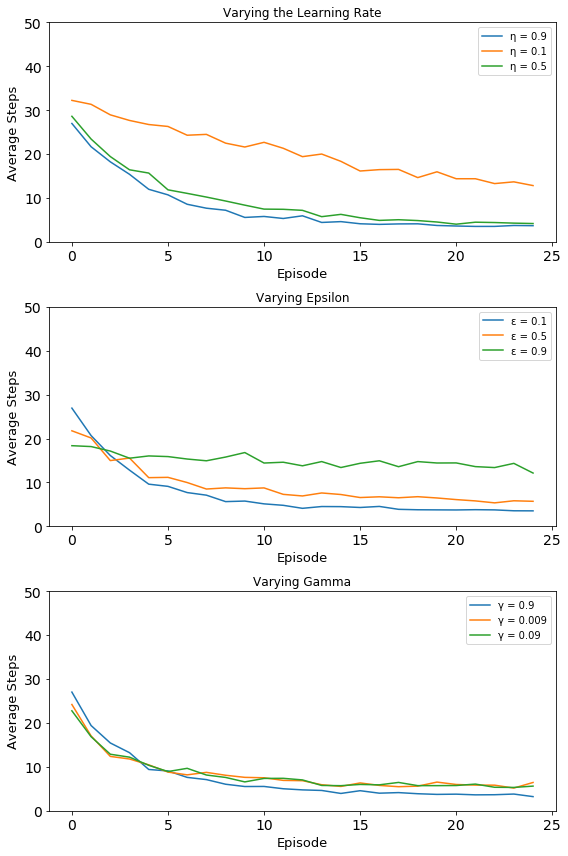

In [7]:
###
### Plotting different parameter values
###

fig, bunchOfAxes = plt.subplots(3, 1, figsize=(8,12))

axes = bunchOfAxes.flatten()
for axes_idx, variable in enumerate([learning_rates, epsilons, gammas]):
    ax = axes[axes_idx]
    for idx in range(len(variable)):
        if variable == learning_rates:
            title = "Varying the Learning Rate"
            label = "η = " + str(variable[idx])
            steps = lr_steps[idx]
        if variable == epsilons:
            title = "Varying Epsilon"
            label = "ε = " + str(variable[idx])
            steps = ep_steps[idx]
        if variable == gammas:
            title = "Varying Gamma"
            label = "γ = " + str(variable[idx])
            steps = ga_steps[idx]
            
        ax_means = np.mean(steps, axis = 0)
        ax_errors = 2 * np.std(steps, axis = 0) / np.sqrt(repetitions) # errorbars are equal to twice standard error i.e. std/sqrt(samples)

        ax.plot(ax_means, label=label)
        ax.set_xlabel('Episode',fontsize = font_size)
        ax.set_ylabel('Average Steps',fontsize = font_size)
        ax.set_ylim(ymin=0, ymax=50)
        ax.legend()
        ax.set_title(title)
        ax.tick_params(axis = 'both', which='major', labelsize = 14)

plt.tight_layout()
plt.show()